In [1]:
import os
import pandas as pd
import numpy as np
import json
import re
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
results_df = pd.DataFrame()

Throughout this notebook, "old" data refers to the data used in the Severson et al. paper, while "new" data refers to the Battery Archive data. "Combined" or "old+new" data referes to when these two data sources are combined into one dataset.

There are quite a few conditionals in this notebook. Here is what the following booleans represent, as well as their recommended settings for the best elastic net model:

__ct__ [True]: Indicates whether charge throughput is the response variable (vs. cycle life)

__integrated_time_temp_cycles__ [optional]: Indicates whether X.integrated_time_temperature_cycles_1:100' should be a feature in the full model

__ir__ [False]: Indicates whether the internal resistance features should be present in the full model for the old data (internal resistance is not present in the new data)

__log_transformation__ [True]: Indicates whether a log transformation should be applied to the combined data

__scaled__ [True]: Indicates whether a Robust Scaler should be used to scale the data (scaling should always be used in an Elastic Net model)

__old_new_scaler__ [True]: Assuming the 'scaled' conditional is true, indicates that the old and new data should be scaled separately before it is combined (vs. combining first and then scaling)
    
__new_chemistries__ [True]: Indicates that the NCA and NMC battery chemistries should be included in the new data set

__chem_sources__ [True]: Assuming the 'new_chemistries' conditional is true, indicates whether the battery's chemistry (LFP, NCA, NMC) should be included as a feature in every model
    
__test_set__ [2 or 3 (half new or new unchanged)]: Assuming the 'new_chemistries' conditional is true, indicates which test set should be used. Set by stating the index of the desired test set, rather than True/False

    combination: Includes half of the old data and half of the new data in the test set
    new: Includes all of the new data in the test set
    half new: Includes half of the new data in the test set
    new unchanged: Includes the same batteries as were in the test set for the new data analyses
    LFP: Includes all of the LFP batteries in the new data in the test set
    NCA: Includes all of the NCA batteries in the new data in the test set
    NMC: Includes all of the NMC batteries in the new data in the test set
    old: Includes observations 84-139 of the old data set (these are the indexes not included in the initial old data analysis)
    
__sources__ [True]: Indicates whether the data's source (old data or battery archive data) should be included as a feature every model for the combined data

__environ__ [False]: Indicates whether the data's environment conditions are included. There are four variables:
    
    Temperature: Temperature the battery is tested at
    DOD: Depth of Discharge
    Discharge_rate: 
    Charge_rate: 
    

In [148]:
#True if using charge_throughput as response variable, False if using cycle life (X.capacity_0.8)
ct = True

#True if including 'X.integrated_time_temperature_cycles_1:100' to full model, False if not
integrated_time_temp_cycles = False

#True if including internal resistance for old data, False if not (no internal resistance variable for new data)
ir = False

#True if applying a log transformtion to combined data, False if no transformation
log_transformation = True

#True if scaling explanatory variables with Robust Scaler, False otherwise (necessary for elastic net)
scaled = True

if scaled:
    #True if using old and new data scaled separately in combined data, False if using a separate scaler for all combined data
    old_new_scaler = True

#True if using all battery chemistries, False if only LFP
new_chemistries = True

if new_chemistries:
    #True if tracking the sources of the new chemistries, False if not
    chem_sources = True
    
    #Identifies the combined data test set's chemistry, or identifies that there will be all new data or a combination all data
    #Old data will not be used if LFP is selected, but will be used if combination is selected
    test_set = ["combination", "new", "half new", "new unchanged", "LFP", "NCA", "NMC", "old"]
    test_set = test_set[7]
    
else:
    chem_sources = False
    test_set = ["combination", "new", "half new", "new unchanged", "LFP", "old", "half"]
    test_set = test_set[3]

#True if identifying the source of the data (old, new), False if not
sources = True

#True if using new environment variables
environ = True

In [149]:
cond = pd.Series({"ct": ct, "time_temp_cycle":integrated_time_temp_cycles, "log_y": log_transformation, "ir": ir, 
                  "standardized": scaled, "environ":environ, "sources_ind": sources, "other_chem": new_chemistries,
                  "separate_scaler": old_new_scaler})

When we reach a conditional, we create an if statement indicating whether the conditional is true. If the conditional is true, then we add whatever code necessary to meet the conditional, which is often only a few lines.

## Reading in the Data

You will need to change the path variable to fit where the data is stored. The data must be featurized through TRI's beep library in order to read in correctly. All necessary featurized data should already be present in the TRI-Capstone GitHub repo [https://github.com/ayakkala1/TRI-Capstone].

In [150]:
# David
# path = "E:/Data/TRI/"

# old_d_dir = path + "FastCharge/features/DeltaQFastCharge"
# old_t_dir = path + "FastCharge/features/TrajectoryFastCharge"

#Folder
path = "./features/"

old_d_dir = path + "DeltaQFastCharge/"
old_t_dir = path + "TrajectoryFastCharge/"


def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if ".json" in fullPath:
            allFiles.append(fullPath)
    return allFiles

old_d_list = getListOfFiles(old_d_dir)
old_t_list = getListOfFiles(old_t_dir)

In [151]:
def get_new_names(d_list):
    new_names = []
    for file in d_list:
        new_names.append(re.findall("CH(.*?)\_f", file)[0])
    return new_names

def make_df(file_list, batch=False):
    df = pd.DataFrame()
    for file in file_list:
        with open(file) as data_file:    
            data = json.load(data_file)
            data_df = pd.json_normalize(data)
            df = pd.concat([df,data_df])
    df.reset_index(drop=True,inplace=True)
    if batch:
        df['bat_num'] = get_new_names(file_list)
    return df

def merge_df(d_df, t_df):
    df_full = d_df.merge(t_df, left_index=True, right_index=True)

    # Making values not stored as lists
    for column in df_full.columns:
        if "X." in column:
            df_full[column] = df_full[column].apply(lambda x: x[0])

    df_full.reset_index(inplace=True)
    return df_full

In [152]:
old_d_df = make_df(old_d_list, batch=True)
old_d_df.head()

batches = []
for i in old_d_df['metadata.protocol']:
    if '2017-05' in i:
        batches.append('b1')
    elif '2017-06' in i:
        batches.append('b2')
    elif '2018-04' in i:
        batches.append('b3')

old_d_df['batches'] = batches
old_d_df['bat_name'] = old_d_df['batches'] + 'c' + old_d_df['bat_num']

In [153]:
# for matt - I don't have the full old data
# old_d_df = make_df(old_d_list, batch=True)
# old_d_df.head()

# batches = []
# for i in old_d_df['name']:
#     if "b1" in i:
#         batches.append('b1')
#     elif 'b2' in i:
#         batches.append('b2')
#     elif 'b3' in i:
#         batches.append('b3')

# old_d_df['batches'] = batches
# old_d_df['bat_name'] = old_d_df['batches'] + 'c' + old_d_df['bat_num']

In [154]:
old_t_df = make_df(old_t_list)
old_t_df.head()

,@module,@class,name,@version,X.capacity_0.98,X.capacity_0.95,X.capacity_0.92,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[127],[269],[376],[423],[449],[467],[483],el150800440551,2017-06-30_tests\20170630-4_4C_55per_6C.sdu,18,0.98,0.78,0.03
1,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[125],[276],[426],[528],[613],[668],[668],el150800737229,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,15,0.98,0.78,0.03
2,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[774],[774],[774],[774],[774],[774],[774],el150800737366,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,29,0.98,0.78,0.03
3,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[543],[543],[543],[543],[543],[543],[543],el150800737234,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,37,0.98,0.78,0.03
4,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[1011],[1011],[1011],[1011],[1011],[1011],[1011],el150800737329,2018-04-12_batch8\20180412-5C_67per_4C_newstru...,9,0.98,0.78,0.03


In [155]:
old_t_df

,@module,@class,name,@version,X.capacity_0.98,X.capacity_0.95,X.capacity_0.92,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode,metadata.protocol,metadata.channel_id,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
0,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[127],[269],[376],[423],[449],[467],[483],el150800440551,2017-06-30_tests\20170630-4_4C_55per_6C.sdu,18,0.98,0.78,0.03
1,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[125],[276],[426],[528],[613],[668],[668],el150800737229,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,15,0.98,0.78,0.03
2,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[774],[774],[774],[774],[774],[774],[774],el150800737366,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,29,0.98,0.78,0.03
3,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[543],[543],[543],[543],[543],[543],[543],el150800737234,2018-04-12_batch8\20180412-3_7C_31per_5_9C_new...,37,0.98,0.78,0.03
4,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[1011],[1011],[1011],[1011],[1011],[1011],[1011],el150800737329,2018-04-12_batch8\20180412-5C_67per_4C_newstru...,9,0.98,0.78,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[250],[250],[250],[250],[483],[503],[522],el150800460610,2017-06-30_tests\20170630-4_9C_61per_4_5C.sdu,24,0.98,0.78,0.03
135,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[249],[368],[416],[443],[462],[480],[497],el150800460613,2017-06-30_tests\20170630-6C_4per_4_75C.sdu,45,0.98,0.78,0.03
136,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[296],[368],[400],[420],[435],[449],[464],el150800460627,2017-06-30_tests\20170630-5_6C_58per_3_5C.sdu,39,0.98,0.78,0.03
137,beep.featurize,TrajectoryFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,[335],[415],[450],[472],[491],[509],[527],el150800460641,2017-06-30_tests\20170630-5_2C_58per_4C.sdu,33,0.98,0.78,0.03


In [156]:
old_df_full = merge_df(old_d_df, old_t_df)
old_df_full.sort_values(by=['bat_name'],inplace=True)
old_df_full.head()

,index,@module_x,@class_x,name_x,@version_x,X.discharge_capacity_cycle_2,X.max_discharge_capacity_difference,X.discharge_capacity_cycle_100,X.integrated_time_temperature_cycles_1:100,X.charge_time_cycles_1:5,...,X.capacity_0.89,X.capacity_0.86,X.capacity_0.83,X.capacity_0.8,metadata.barcode_y,metadata.protocol_y,metadata.channel_id_y,metadata.parameters.thresh_max_cap,metadata.parameters.thresh_min_cap,metadata.parameters.interval_cap
98,98,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.069159,0.609605,1.075878,194523.331238,768.000000,...,1191,1191,1191,1191,EL150800460514,2017-05-12_TESTS\20170512-3_6C-80PER_3_6C.SDU,0,0.98,0.78,0.03
13,13,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.021925,0.234529,1.010972,163310.066862,819.200012,...,528,663,665,665,EL150800460514,2017-05-12_TESTS\20170512-3_6C-80PER_3_6C.SDU,0,0.98,0.78,0.03
78,78,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.072973,0.607773,1.079325,182982.491752,563.200012,...,583,605,625,638,EL150800463886,2017-05-12_TESTS\20170512-4_8C-80PER_4_8C.SDU,9,0.98,0.78,0.03
96,96,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.070200,0.609325,1.061485,178767.125004,537.599976,...,441,492,525,536,EL150800464002,2017-05-12_TESTS\20170512-5_4C-80PER_5_4C.SDU,10,0.98,0.78,0.03
97,97,beep.featurize,DeltaQFastCharge,/mnt/c/Users/sjrt1/Documents/School/Winter2021...,2021.1.11.15,1.080072,0.606653,1.076906,184036.176107,512.000000,...,492,526,549,561,EL150800463871,2017-05-12_TESTS\20170512-5_4C-80PER_5_4C.SDU,11,0.98,0.78,0.03


In [157]:
path = "./"
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")

In [158]:
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

In [159]:
if environ:
    old_ct["Temperature"] = 30
    old_ct["DOD"] = 100
    old_ct["Discharge_rate"] = 4
    old_ct["Charge_rate"] = 4.8

In [160]:
new_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")

if new_chemistries:
    nca_df = pd.read_csv(path + "NewData/charge_throughputs_BA_NCA.csv")
    nmc_df = pd.read_csv(path + "NewData/charge_throughputs_BA_NMC.csv")
    
    chemistries = ["LFP", "NCA", "NMC"]
    dfs = [new_ct, nca_df, nmc_df]
    
    for i in range(len(chemistries)):
        chem = chemistries[i]
        for j in range(len(dfs)):
            df = dfs[j]
            
            if i == j:
                df[chem] = 1
            else:
                df[chem] = -1
            
            dfs[j] = df
        
    new_ct = pd.concat([df for df in dfs], ignore_index=True)

## Models

Setting the model variables for the old data

The variance, discharge, and full models were all introduced in the Severson et al. paper. See the paper for more information.

In [161]:
variance_model_features = ['X.abs_variance_discharge_capacity_difference_cycles_2:100']
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference'
                            ]
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5']

if integrated_time_temp_cycles:
    full_model_features.append('X.integrated_time_temperature_cycles_1:100')

if ir:
    full_model_features.append('X.min_internal_resistance_cycles_2:100')
    full_model_features.append('X.internal_resistance_difference_cycles_2:100')
    
if environ:
    variance_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))
    discharge_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))
    full_model_features.extend(('Temperature', 'DOD', 'Discharge_rate', 'Charge_rate'))

if ct:
    y = 'charge_throughput'
else:
    y = 'cycle_index'

In [162]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import RobustScaler

We fit the 3 model feature groups (variance, discharge, full), 3 data types (old, new, combined), and 2 model types (basic linear regression, elastic net) for 18 total model combinations. Throughout this notebook, we plot true vs. predicted values, RMSE comparisons, and MAPE comparisons to evaluate these models.

## Old Data

The following train-test split does not include all of the old data. This is because observations not included in this train-test split were collected at a separate time. This is the split used in the Severson et al. paper, and it is the one we will use when considering only the old data. Once we combine the old and new data, however, we will use all batteries from the old dataset, not just the 80 or so that are included now.

In [163]:
len(old_ct)

139

In [164]:
train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81]
test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]

We do not want to immediately apply the scaler to old_ct, since we want to still be able to see the true values if necessary. We will fit the scaler to the training set for each model, then apply it to the test set.

If 'old_new_scaler' is set to true, we create another file, X_all_old, that is the scaled version of all data in old_ct. This is the dataset we will combine with the scaled new data. The scaler for this data is also fit to the train set, then applied to all of the data.

In [165]:
if scaled:
    
    all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))
    
    def scale(train, test):
        scaler = RobustScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        return [train_data, test_data]
    
    if old_new_scaler:
        X_train_all_old = old_ct.iloc[train_ind][all_model_features]
        temp_test_ind = list(set(old_ct.index)-set(train_ind))
        X_test_all_old = old_ct.iloc[temp_test_ind][all_model_features]

        X_train_all_old, X_test_all_old = scale(X_train_all_old, X_test_all_old)

        X_train_all_old[y] = old_ct.iloc[train_ind][y]
        X_test_all_old[y] = old_ct.iloc[temp_test_ind][y]

        X_all_old = X_train_all_old.append(X_test_all_old)
        
        X_test_all_old = X_test_all_old.iloc[test_ind]

### Variance Model [Old Data]

#### Linear Regression

In [166]:
X_train_var = old_ct.iloc[train_ind][variance_model_features]

y_train = old_ct.iloc[train_ind][[y]]

X_test_var = old_ct.iloc[test_ind][variance_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if scaled:
    X_train_var, X_test_var = scale(X_train_var, X_test_var)

In [167]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

In [168]:
rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Basic Linear Regression Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Test RMSE:  214.30059910503823
Mean % Test Error:  14.850105828362189


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR) [Old Data]')

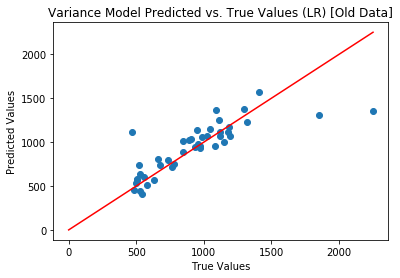

In [169]:
# Variance model
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR) [Old Data]")

#### Elastic Net

In [170]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
    mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)*100
    mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)*100

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)
    train_mapes.append(mape_train_en_var)
    test_mapes.append(mape_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

In [171]:
elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]
mape_train_var_en = train_mapes[best_model_index]
mape_test_var_en = test_mapes[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)
print("Test Mean Absolute % Error: ", mape_test_var_en)

Variance Elastic Net Model
l1_ratio = 1.0
Test RMSE:  214.31490921731066
Test Mean Absolute % Error:  14.846083042128644


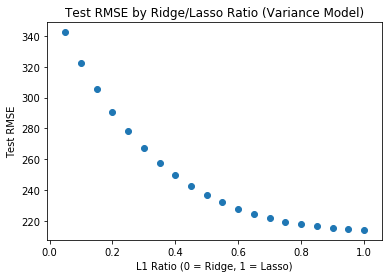

In [172]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN) [Old Data]')

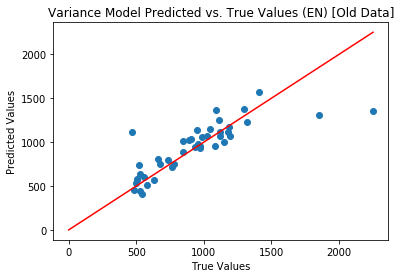

In [173]:
#Elastic Net
min_var = y_test.min()[0]
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN) [Old Data]")

In [174]:
model_name = "Variance"
source = "Old"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_var, "EN_rmse":rmse_test_var_en, 
                                                      "L_mape": mape_test_var, "EN_mape":mape_test_var_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_var.coef_})),
                               ignore_index=True)

#### From paper (Variance Model)
* Training RMSE: 103
* Test RMSE: 138
* Mean % Train Error: 14.1
* Mean % Test Error: 14.7

### Discharge Model [Old Data]

#### Linear Regression

In [175]:
X_train_dis = old_ct.iloc[train_ind][discharge_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_dis = old_ct.iloc[test_ind][discharge_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if scaled:
    X_train_dis, X_test_dis = scale(X_train_dis, X_test_dis)

In [176]:
reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

In [177]:
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Basic Linear Regression Model")
# print("Training RMSE: ", rmse_train_dis)
print("Test RMSE: ", rmse_test_dis)
# print("Train Mean % Error: ", mape_train_dis)
print("Test Mean % Error: ", mape_test_dis)

Discharge Basic Linear Regression Model
Test RMSE:  335.35099101854763
Test Mean % Error:  19.83082949660379


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR) [Old Data]')

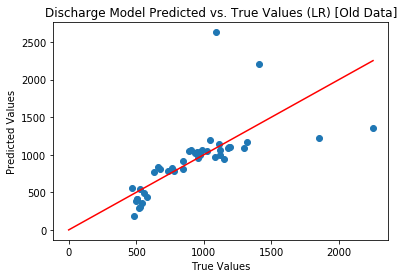

In [178]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR) [Old Data]")

#### Elastic Net

In [179]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
    mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)*100
    mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)*100

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)
    train_mapes.append(mape_train_en_dis)
    test_mapes.append(mape_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

In [180]:
elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]
mape_train_dis_en = train_mapes[best_model_index]
mape_test_dis_en = test_mapes[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)
print("Test Mean Absolute % Error: ", mape_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 1.0
Test RMSE:  320.48757241913233
Test Mean Absolute % Error:  17.04233578049506


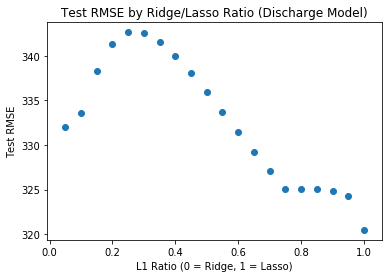

In [181]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN) [Old Data]')

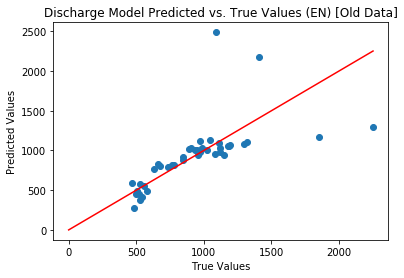

In [182]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN) [Old Data]")

#### From paper (Discharge Model)
* Training RMSE: 76
* Test RMSE: 91
* Mean % Train Error: 9.8
* Mean % Test Error: 13.0

In [183]:
model_name = "Discharge"
source = "Old"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_dis, "EN_rmse":rmse_test_dis_en, 
                                                      "L_mape": mape_test_dis, "EN_mape":mape_test_dis_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_dis.coef_})),
                               ignore_index=True)

### Full Model [Old Data]

#### Linear Regression

In [184]:
X_train_full = old_ct.iloc[train_ind][full_model_features]
y_train = old_ct.iloc[train_ind][[y]]

X_test_full = old_ct.iloc[test_ind][full_model_features]
y_test = old_ct.iloc[test_ind][[y]]

if scaled:
    X_train_full, X_test_full = scale(X_train_full, X_test_full)

In [185]:
reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

In [186]:
rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Test RMSE:  216.14178331557875
Mean % Test Error:  0.16906215860653007


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR) [Old Data]')

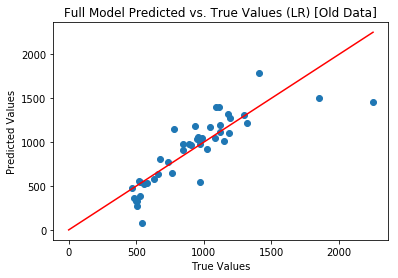

In [187]:
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR) [Old Data]")

#### Elastic Net

In [188]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
    mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)*100
    mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)*100

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)
    train_mapes.append(mape_train_en_full)
    test_mapes.append(mape_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

In [189]:
elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]
mape_train_full_en = train_mapes[best_model_index]
mape_test_full_en = test_mapes[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)
print("Test Mean Absolute % Error: ", mape_test_full_en)

Full Elastic Net Model
l1_ratio = 0.9
Test RMSE:  202.13017707074727
Test Mean Absolute % Error:  14.131775373914499


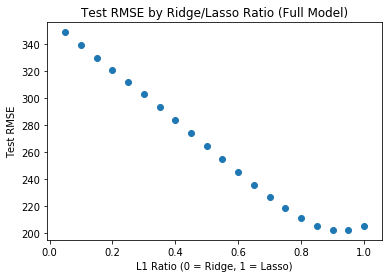

In [190]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN) [Old Data]')

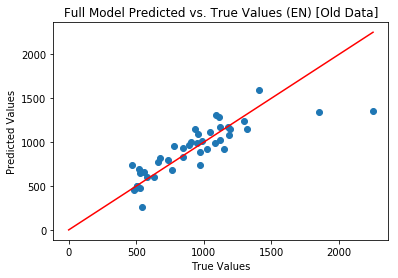

In [191]:
#Elastic Net
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN) [Old Data]")

In [192]:
model_name = "Full"
source = "Old"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_full, "EN_rmse":rmse_test_full_en, 
                                                      "L_mape": mape_test_full, "EN_mape":mape_test_full_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_full.coef_})),
                               ignore_index=True)

#### From paper (Full Model)
* Training RMSE: 51
* Test RMSE: 118
* Mean % Train Error: 5.6
* Mean % Test Error: 14.1

### Old Data Plots

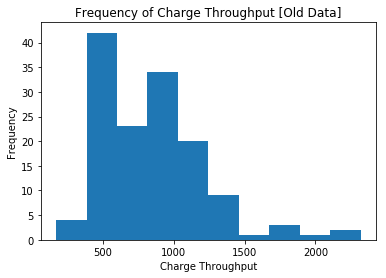

In [193]:
plt.hist(old_ct[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput [Old Data]')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life [Old Data]')

In [194]:
old_data_metrics = pd.DataFrame(data = {
    
                               "Model & Source": ["Var (Linear)", "Var (E.N.)", "Var (Paper)",
                                                  "Disc (Linear)", "Disc (E.N.)", "Disc (Paper)",
                                                  "Full (Linear)", "Full (E.N.)", "Full (Paper)"],
                               
                               "Model": ["Variance", "Variance", "Variance",
                                         "Discharge", "Discharge", "Discharge",
                                         "Full", "Full", "Full"],
                                        
                               "Source": ["Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)",
                                          "Us (Basic Linear)", "Us (Elastic Net)", "Paper (Elastic Net)"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en, 103,
                                              rmse_train_dis, rmse_train_dis_en, 76,
                                              rmse_train_full, rmse_train_full_en, 51],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en, 138,
                                             rmse_test_dis, rmse_test_dis_en, 91, 
                                             rmse_test_full, rmse_test_full_en, 118],
                               
                               "Train MAPE": [mape_train_var, mape_train_var_en, 14.1,
                                              mape_train_dis, mape_train_dis_en, 9.8,
                                              mape_train_full, mape_train_full_en, 5.6],
                               
                               "Test MAPE": [mape_test_var, mape_test_var_en, 14.7,
                                             mape_test_dis, mape_test_dis_en, 13.0,
                                             mape_test_full, mape_test_full_en, 14.1]})

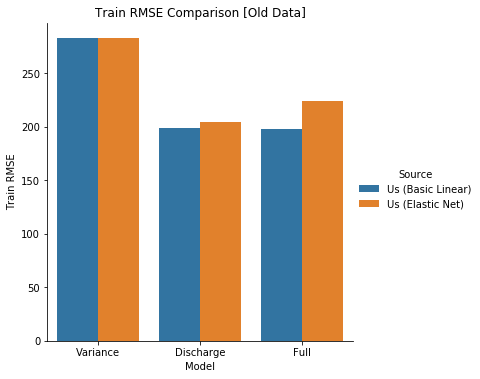

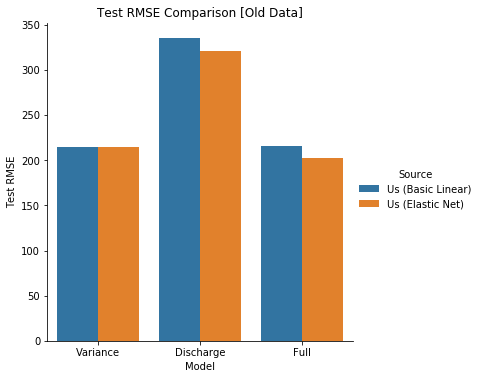

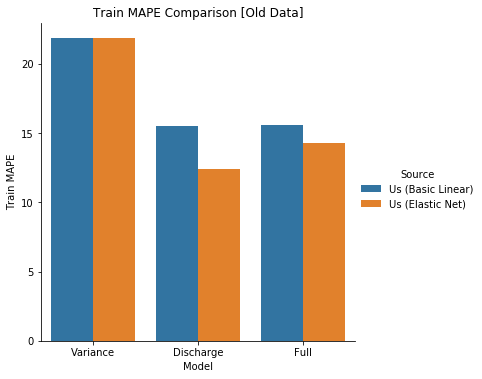

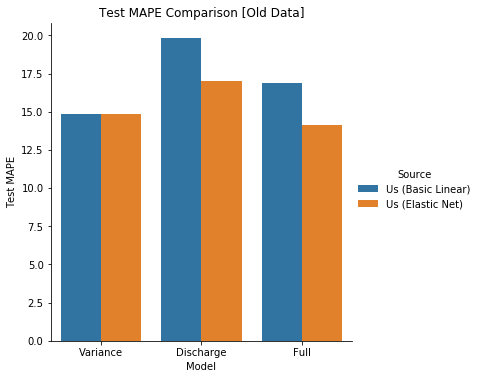

In [195]:
if ct:
    old_data_metrics = old_data_metrics.iloc[[0,1,3,4,6,7]]
for column in old_data_metrics.columns[3:]:
    sns.catplot(data = old_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison [Old Data]")

In [196]:
#Removing internal_resistance features for models with new data
if ir:
    full_model_features.remove('X.min_internal_resistance_cycles_2:100')
    full_model_features.remove('X.internal_resistance_difference_cycles_2:100')
    
    if scaled:
        all_model_features.remove('X.min_internal_resistance_cycles_2:100')
        all_model_features.remove('X.internal_resistance_difference_cycles_2:100')

## New Data

### Reading in the data

In [197]:
new_df = pd.read_csv(path + "NewData/LFPBatteries.csv")

if new_chemistries:
    nca = pd.read_csv(path + "NewData/NCABatteries.csv")
    nmc = pd.read_csv(path + "NewData/NMCBatteries.csv")
    
    new_df = pd.concat([new_df, nca, nmc], ignore_index=True)
    
    chemistries = ["X.LFP", "X.NCA", "X.NMC"]
    
    if chem_sources:
        variance_model_features = variance_model_features + chemistries
        discharge_model_features = discharge_model_features + chemistries
        full_model_features = full_model_features + chemistries

In [198]:
new_ct_full = new_df.merge(how = 'inner',right = new_ct, left_index = True, right_index=True)
new_ct_full = new_ct_full.add_prefix('X.')
new_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
new_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)

if environ:
    new_ct_full["Temperature"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
    new_ct_full["DOD"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
    new_ct_full["Charge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))
    new_ct_full["Discharge_rate"] = new_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))

In [199]:
new_ct_full

,X.abs_first_discharge_capacity_difference_cycles_2:100,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.abs_mean_discharge_capacity_difference_cycles_2:100,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.battery_index,X.charge_time_cycles_1:5,X.discharge_capacity_cycle_100,X.discharge_capacity_cycle_2,...,X.battery,charge_throughput,X.cycle_index,X.LFP,X.NCA,X.NMC,Temperature,DOD,Charge_rate,Discharge_rate
0,-3.309824,1.867028,-2.742859,-0.446806,0.584775,-3.166992,0,5760.000000,1.032,1.030,...,LFP_15C_0-100_0.5-1C_a_CH00,4524.021,4550.0,1,-1,-1,15,100,0.5,1.0
1,-3.019408,2.349816,-2.648706,-0.208776,0.993881,-3.056759,1,5785.600098,1.042,1.040,...,LFP_15C_0-100_0.5-1C_a_CH01,3577.625,3552.0,1,-1,-1,15,100,0.5,1.0
2,-2.312774,1.694375,-1.917594,-0.195631,0.655882,-2.478396,2,5811.200195,1.030,1.030,...,LFP_15C_0-100_0.5-1C_a_CH02,3680.164,3760.0,1,-1,-1,15,100,0.5,1.0
3,-2.677882,1.495850,-2.076420,-0.631730,0.057256,-2.981589,3,5785.600098,1.025,1.029,...,LFP_15C_0-100_0.5-1C_a_CH03,3655.051,3753.0,1,-1,-1,15,100,0.5,1.0
4,-2.005443,0.393445,-1.682799,-0.189399,-0.220132,-1.291194,4,5785.600098,1.059,1.067,...,LFP_15C_0-100_0.5-1C_a_CH04,3058.955,3049.0,1,-1,-1,15,100,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,-0.701052,0.395033,-1.747525,0.351140,-0.299305,-0.327336,27,2150.399902,2.617,2.945,...,NMC_25C_40-60_0.5-3C_b_CH25_struct,6965.715,11148.0,-1,-1,1,25,60,0.5,3.0
79,-0.766416,0.488745,-1.573092,0.371751,-2.863442,-0.333385,28,2150.399902,2.642,2.967,...,NMC_35C_0-100_0.5-1C_a_CH26_struct,1627.971,785.0,-1,-1,1,35,100,0.5,1.0
80,-0.894346,0.547362,-1.822007,0.342701,-0.171990,-0.438810,29,2124.800049,2.645,2.899,...,NMC_35C_0-100_0.5-1C_b_CH27_struct,1956.561,785.0,-1,-1,1,35,100,0.5,1.0
81,-0.653234,0.191814,-2.706233,0.161041,-0.187615,-0.512972,30,2150.399902,2.653,2.957,...,NMC_35C_0-100_0.5-1C_c_CH28_struct,1638.455,784.0,-1,-1,1,35,100,0.5,1.0


In [200]:
train_ind = [i for i in range(0, len(new_ct_full), 2)]
test_ind = [i for i in range(1, len(new_ct_full), 2)]

new_test_ind = test_ind

In [201]:
if scaled:
    if old_new_scaler:
        if new_chemistries & chem_sources:
            all_model_features = all_model_features + chemistries
        X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_train_all_new.dropna(axis=0, inplace=True)
        X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_test_all_new.dropna(axis=0, inplace=True)

        X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

        X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
        X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
        X_all_new = X_train_all_new.append(X_test_all_new)

In [202]:
X_all_new

,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.slope_discharge_capacity_cycle_number_2:100,X.intercept_discharge_capacity_cycle_number_2:100,X.discharge_capacity_cycle_2,X.charge_time_cycles_1:5,Temperature,DOD,Discharge_rate,Charge_rate,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.max_discharge_capacity_difference,X.abs_skew_discharge_capacity_difference_cycles_2:100,X.LFP,X.NCA,X.NMC,charge_throughput
0,-0.671244,-1.032908,1.147150,-0.924180,-0.929348,0.966216,-1.0,0.0,0.0,0.0,1.462216,-0.882938,1.080344,1.0,0.0,0.0,4524.021
2,-0.329434,-0.686155,1.146856,-0.925186,-0.929348,0.979730,-1.0,0.0,0.0,0.0,1.263151,-0.886251,1.188896,1.0,0.0,0.0,3680.164
4,-0.320952,-0.088323,1.100553,-0.904178,-0.911067,0.972973,-1.0,0.0,0.0,0.0,-0.236789,-0.861403,-0.148437,1.0,0.0,0.0,3058.955
6,-0.255616,-0.590864,1.140131,-0.921433,-0.926877,0.972973,-1.0,0.0,0.0,0.0,1.298193,-0.881281,1.428713,1.0,0.0,0.0,3530.338
8,-0.778695,-0.683816,1.137143,-0.915101,-0.919960,0.972973,-1.0,0.0,0.0,0.0,0.131079,-0.875759,0.000000,1.0,0.0,0.0,3058.092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.353815,0.428084,-0.216197,0.073492,0.026680,-0.013514,0.0,0.0,2.0,0.0,-0.633154,0.138045,-0.458303,0.0,0.0,1.0,1393.135
69,0.354040,0.438714,-0.240450,0.077634,0.030632,0.000000,0.0,0.0,2.0,0.0,-0.673930,0.143567,-0.827211,0.0,0.0,1.0,2235.783
77,0.431034,0.411659,-0.144427,0.072703,0.025692,0.020270,0.0,-40.0,2.0,0.0,-0.294569,0.122584,-0.422702,0.0,0.0,1.0,8109.346
79,0.442684,0.393996,-0.165913,0.073857,0.027668,0.013514,1.0,0.0,0.0,0.0,-0.126910,0.128106,-4.183742,0.0,0.0,1.0,1627.971


### Variance Model [New Data]

#### Linear Regression

In [203]:
X_train_var = new_ct_full.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True)
y_train = new_ct_full.iloc[X_train_var.index][[y]]

X_test_var = new_ct_full.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True)
y_test = new_ct_full.iloc[X_test_var.index][[y]]

if scaled:
    X_train_var, X_test_var = scale(X_train_var, X_test_var)

In [204]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

In [205]:
rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Basic Linear Regression Model")
# print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
# print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Test RMSE:  1175.0380725070397
Mean % Test Error:  35.86005527931025


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR) [New Data]')

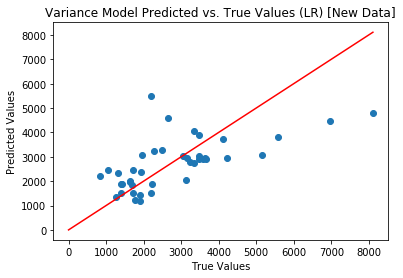

In [206]:
# Linear Regression
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR) [New Data]")

#### Elastic Net

In [207]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
    mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)*100
    mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)*100

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)
    train_mapes.append(mape_train_en_var)
    test_mapes.append(mape_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

In [208]:
elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]
mape_train_var_en = train_mapes[best_model_index]
mape_test_var_en = test_mapes[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)
print("Test Mean Absolute % Error: ", mape_test_var_en)

Variance Elastic Net Model
l1_ratio = 1.0
Test RMSE:  1430.5009397581955
Test Mean Absolute % Error:  48.60216422775723


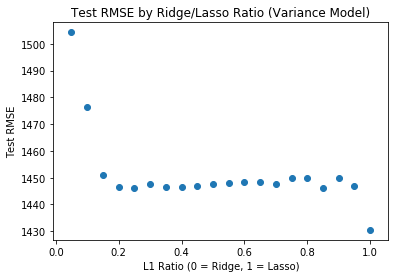

In [209]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN) [New Data]')

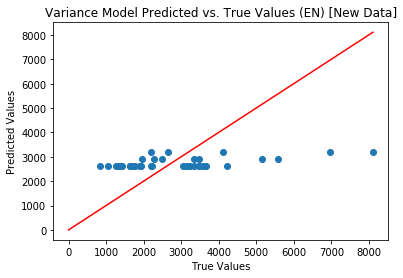

In [210]:
#Elastic Net
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN) [New Data]")

In [211]:
model_name = "Variance"
source = "New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_var, "EN_rmse":rmse_test_var_en, 
                                                      "L_mape": mape_test_var, "EN_mape":mape_test_var_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_var.coef_,
                                                      "test_ind":test_ind})),
                               ignore_index=True)

### Discharge Model [New Data]

#### Linear Regression

In [212]:
X_train_dis = new_ct_full.iloc[train_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_train_dis.dropna(axis=0, inplace=True)
y_train = new_ct_full.iloc[X_train_dis.index][[y]]

X_test_dis = new_ct_full.iloc[test_ind][discharge_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_dis.dropna(axis=0, inplace=True)
y_test = new_ct_full.iloc[X_test_dis.index][[y]]

if scaled:
    X_train_dis, X_test_dis = scale(X_train_dis, X_test_dis)

In [213]:
reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

In [214]:
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Test RMSE:  924.6478860348246
Mean % Test Error:  0.29745366879273927


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR) [New Data]')

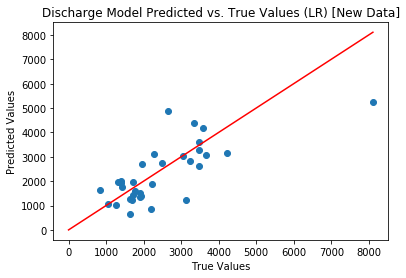

In [215]:
# Linear Regression
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR) [New Data]")

#### Elastic Net

In [216]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
    mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)*100
    mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)*100

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)
    train_mapes.append(mape_train_en_dis)
    test_mapes.append(mape_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

In [217]:
elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]
mape_train_dis_en = train_mapes[best_model_index]
mape_test_dis_en = test_mapes[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)
print("Test Mean Absolute % Error: ", mape_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.35
Test RMSE:  1137.4466513364969
Test Mean Absolute % Error:  40.56062318904791


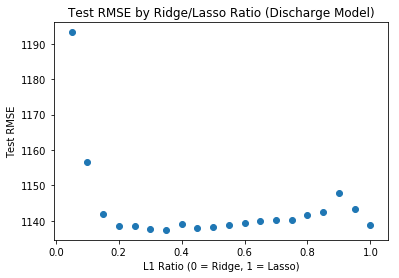

In [218]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN) [New Data]')

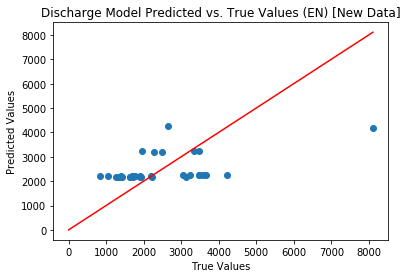

In [219]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN) [New Data]")

In [220]:
model_name = "Discharge"
source = "New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_dis, "EN_rmse":rmse_test_dis_en, 
                                                      "L_mape": mape_test_dis, "EN_mape":mape_test_dis_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_dis.coef_,
                                                      "test_ind":test_ind})),
                               ignore_index=True)

### Full Model [New Data]

#### Linear Regression

In [221]:
X_train_full = new_ct_full.iloc[train_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_train_full.dropna(axis=0, inplace=True) 
y_train = new_ct_full.iloc[X_train_full.index][[y]]

X_test_full = new_ct_full.iloc[test_ind][full_model_features].replace([np.inf, -np.inf, 0], np.nan)
X_test_full.dropna(axis=0, inplace=True) 
y_test = new_ct_full.iloc[X_test_full.index][[y]]

if scaled:
    X_train_full, X_test_full = scale(X_train_full, X_test_full)

In [222]:
reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

In [223]:
rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Test RMSE:  930.1035107548531
Mean % Test Error:  0.2775043329404017


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR) [New Data]')

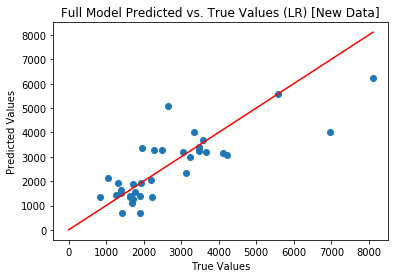

In [224]:
#Linear Regression
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR) [New Data]")

#### Elastic Net

In [225]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )
    
    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
    mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)*100
    mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)*100

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)
    train_mapes.append(mape_train_en_full)
    test_mapes.append(mape_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

In [226]:
elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]
mape_train_full_en = train_mapes[best_model_index]
mape_test_full_en = test_mapes[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)
print("Test Mean Absolute % Error: ", mape_test_full_en)

Full Elastic Net Model
l1_ratio = 0.95
Test RMSE:  1302.6628623860872
Test Mean Absolute % Error:  36.52856988275888


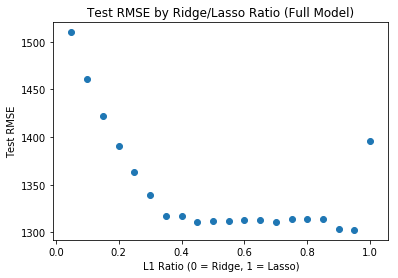

In [227]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN) [New Data]')

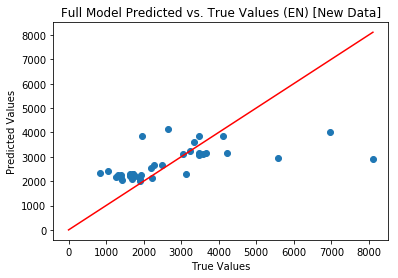

In [228]:
#Elastic Net
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN) [New Data]")

In [229]:
model_name = "Full"
source = "New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_full, "EN_rmse":rmse_test_full_en, 
                                                      "L_mape": mape_test_full, "EN_mape":mape_test_full_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_full.coef_,
                                                      "test_ind":test_ind})),
                               ignore_index=True)

### New Data Plots

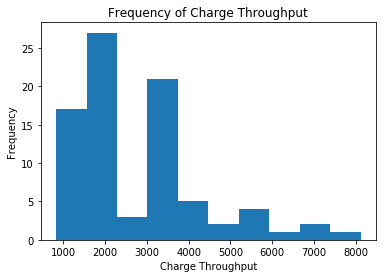

In [230]:
plt.hist(new_ct_full[y])
plt.ylabel('Frequency')
if ct:
    plt.xlabel('Charge Throughput')
    plt.title('Frequency of Charge Throughput')
else:
    plt.xlabel('Cycle Life')
    plt.title('Frequency of Cycle Life (New Data)')

In [231]:
new_data_metrics = pd.DataFrame(data = {
    
                               "Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                  "Disc (Linear)", "Disc (E.N.)",
                                                  "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en],
                               
                               "Train MAPE": [mape_train_var, mape_train_var_en,
                                              mape_train_dis, mape_train_dis_en,
                                              mape_train_full, mape_train_full_en],
                               
                               "Test MAPE": [mape_test_var, mape_test_var_en,
                                             mape_test_dis, mape_test_dis_en,
                                             mape_test_full, mape_test_full_en]})

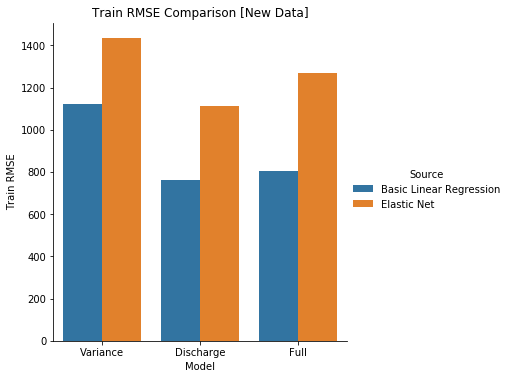

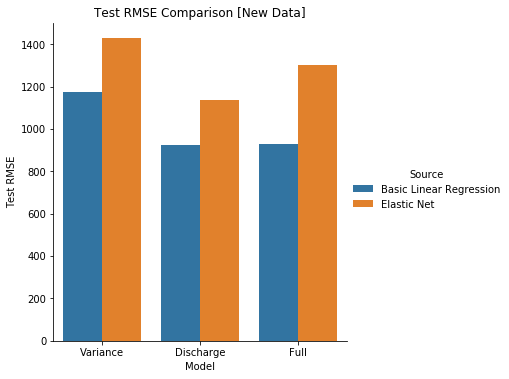

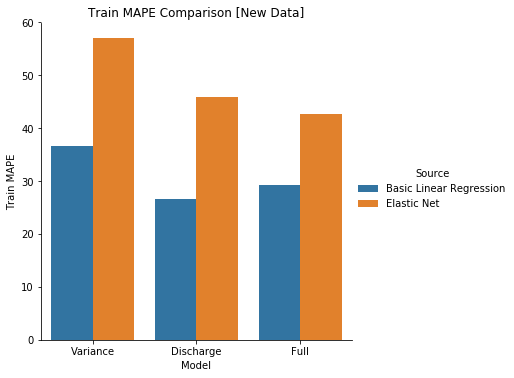

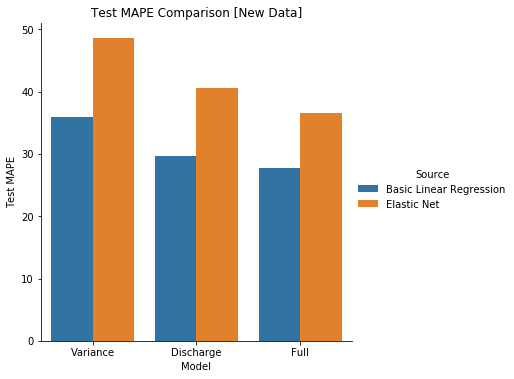

In [232]:
for column in new_data_metrics.columns[3:]:
    sns.catplot(data = new_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison [New Data]")

In [233]:
test_set = ["combination", "new", "half new", "new unchanged", "LFP", "old", "half"]
test_set = test_set[3]

## Combined (Old+New) Data

### Combining the old and new data

In [234]:
# if sources:
#     old_ct["Source"] = -1
#     new_ct_full["Source"] = 1
#     variance_model_features.append("Source")
#     discharge_model_features.append("Source")
#     full_model_features.append("Source")

# if new_chemistries & chem_sources:
#     old_ct["X.LFP"] = new_ct_full.iloc[0]["X.LFP"]
#     old_ct["X.NCA"] = new_ct_full.iloc[0]["X.NCA"]
#     old_ct["X.NMC"] = new_ct_full.iloc[0]["X.NMC"]

In [235]:
# full_data = old_ct.append(new_ct_full)
# full_data = full_data.reset_index()

In [236]:
# if scaled:
#     train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
#             35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
#             69, 71, 73, 75, 77, 79, 81]
#     test_ind = [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
#             34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
#             68, 70, 72, 74, 76, 78, 80, 82, 83]

#     all_model_features = full_model_features# + list(set(discharge_model_features)-set(full_model_features))
    
#     def scale(train, test):
#         scaler = RobustScaler()
#         scaler.fit(train)
#         train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
#         test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
#         return [train_data, test_data]
    
#     if old_new_scaler:
#         X_train_all_old = old_ct.iloc[train_ind][all_model_features]
#         temp_test_ind = list(set(old_ct.index)-set(train_ind))
#         X_test_all_old = old_ct.iloc[temp_test_ind][all_model_features]

#         X_train_all_old, X_test_all_old = scale(X_train_all_old, X_test_all_old)

#         X_train_all_old[y] = old_ct.iloc[train_ind][y]
#         X_test_all_old[y] = old_ct.iloc[temp_test_ind][y]

#         X_all_old = X_train_all_old.append(X_test_all_old)
        
#         X_test_all_old = X_test_all_old.iloc[test_ind]

In [237]:
# if scaled:
#     if old_new_scaler:
        
#         train_ind = [i for i in range(0, len(new_ct_full), 2)]
#         test_ind = [i for i in range(1, len(new_ct_full), 2)]

#         if new_chemistries & chem_sources:
#             all_model_features = full_model_features + chemistries
#         X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
#         X_train_all_new.dropna(axis=0, inplace=True)
#         X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
#         X_test_all_new.dropna(axis=0, inplace=True)

#         X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

#         X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
#         X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
#         X_all_new = X_train_all_new.append(X_test_all_new)

In [238]:
new_ct_full.shape

(83, 36)

In [239]:
old_ct.shape

(139, 49)

In [240]:
variance_model_features

['X.abs_variance_discharge_capacity_difference_cycles_2:100',
 'Temperature',
 'DOD',
 'Discharge_rate',
 'Charge_rate',
 'X.LFP',
 'X.NCA',
 'X.NMC']

In [241]:
variance_model_features = variance_model_features[:-3]
discharge_model_features = discharge_model_features[:-3]
full_model_features = full_model_features[:-3]

In [242]:
if scaled:
    
    all_model_features = variance_model_features
    
    def scale(train, test=pd.DataFrame()):
        #print(type(test))
        scaler = RobustScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        if len(test) != 0:
            test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        else:
            test_data = 0
        return [train_data, test_data]
    
    if old_new_scaler:
        # old
        train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81, 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]
        X_train_all_old = old_ct.iloc[train_ind][all_model_features]

        X_train_all_old, X_test_all_old = scale(X_train_all_old)

        X_train_all_old[y] = old_ct.iloc[train_ind][y]

        X_all_old = X_train_all_old

        # new
        train_ind = [i for i in range(0, len(new_ct_full), 2)]
        test_ind = [i for i in range(1, len(new_ct_full), 2)]

        new_test_ind = test_ind

        if new_chemistries & chem_sources:
            all_model_features = all_model_features + chemistries
        X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_train_all_new.dropna(axis=0, inplace=True)
        X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_test_all_new.dropna(axis=0, inplace=True)

        X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

        X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
        X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
        X_all_new = X_train_all_new.append(X_test_all_new)
        
        

In [243]:
X_test_var

,X.abs_variance_discharge_capacity_difference_cycles_2:100,Temperature,DOD,Discharge_rate,Charge_rate,X.LFP,X.NCA,X.NMC
1,-0.967940,-1.0,0.0,0.000000,0.0,1.0,0.0,0.0
3,-0.931908,-1.0,0.0,0.000000,0.0,1.0,0.0,0.0
5,-0.638166,-1.0,0.0,0.000000,0.0,1.0,0.0,0.0
7,-0.686536,-1.0,0.0,0.000000,0.0,1.0,0.0,0.0
9,-0.978470,-1.0,0.0,0.000000,0.0,1.0,0.0,0.0
11,-0.895882,-1.0,0.0,0.000000,0.0,1.0,0.0,0.0
13,-1.223051,-1.0,0.0,0.000000,0.0,1.0,0.0,0.0
15,-1.685119,0.0,-1.0,-0.444444,0.0,1.0,0.0,0.0
17,-1.285805,0.0,-1.0,-0.444444,0.0,1.0,0.0,0.0
19,-2.261600,0.0,-1.0,1.777778,0.0,1.0,0.0,0.0


In [244]:
if sources:
    old_ct["Source"] = -1
    new_ct_full["Source"] = 1
    variance_model_features.append("Source")
    discharge_model_features.append("Source")
    full_model_features.append("Source")

if new_chemistries & chem_sources:
    old_ct["X.LFP"] = new_ct_full.iloc[0]["X.LFP"]
    old_ct["X.NCA"] = new_ct_full.iloc[0]["X.NCA"]
    old_ct["X.NMC"] = new_ct_full.iloc[0]["X.NMC"]
    variance_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    discharge_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    full_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))

In [245]:
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

In [246]:
if scaled:
    if old_new_scaler:
        if sources:
            X_all_old["Source"] = -1
            X_all_new["Source"] = 1
            all_model_features.append("Source")
            
        if new_chemistries & chem_sources:
            X_all_old["X.LFP"] = 1
            X_all_old["X.NCA"] = -1
            X_all_old["X.NMC"] = -1

            for chem in chemistries:
                X_all_new[chem].replace(0, -1, inplace=True)
            
        full_data = X_all_old.append(X_all_new)
        full_data = full_data.reset_index()

In [247]:
if new_chemistries:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)
            
    elif test_set == "NCA":
        test_ind = list(full_data[full_data["X.NCA"] > 0].index)
        
    elif test_set == "NMC":
        test_ind = list(full_data[full_data["X.NMC"] > 0].index)
        
    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
    
else:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)

    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
        
train_ind = list(set(full_data.index) - set(test_ind))
#train_ind = list(full_data.iloc[:84].index) + [j for j in range(139, len(full_data),2)]

c:\users\mattm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


### Variance Model [Combined Data]

#### Linear Regression

In [248]:
X_train_var = full_data.iloc[train_ind][variance_model_features]
X_train_var.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_var.index][[y]]

X_test_var = full_data.iloc[test_ind][variance_model_features]
X_test_var.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_var.index][[y]]

# if scaled:
#     if not old_new_scaler:
#         X_train_var, X_test_var = scale(X_train_var, X_test_var)

# log transformation
if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [249]:
reg_var = LinearRegression().fit(X_train_var,y_train)
y_pred_train_var = reg_var.predict(X_train_var)
y_pred_test_var = reg_var.predict(X_test_var)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_var = np.exp(y_pred_train_var)
    y_pred_test_var = np.exp(y_pred_test_var)

In [250]:
rmse_train_var = np.sqrt(mean_squared_error(y_train, y_pred_train_var))
rmse_test_var = np.sqrt(mean_squared_error(y_test, y_pred_test_var))
mape_train_var = mean_absolute_percentage_error(y_train, y_pred_train_var)*100
mape_test_var = mean_absolute_percentage_error(y_test, y_pred_test_var)*100

print("Variance Basic Linear Regression Model")
print("Training RMSE: ", rmse_train_var)
print("Test RMSE: ", rmse_test_var)
print("Mean % Train Error: ", mape_train_var)
print("Mean % Test Error: ", mape_test_var)

Variance Basic Linear Regression Model
Training RMSE:  863.8239923164497
Test RMSE:  1616.4839871049633
Mean % Train Error:  23.44857362230894
Mean % Test Error:  35.8327646225767


Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (LR) [Combined Data]')

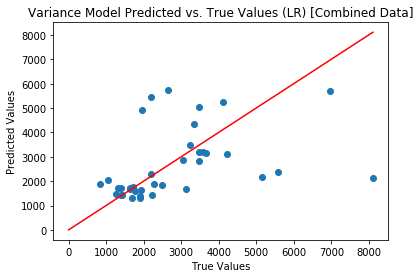

In [251]:
# Variance model
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (LR) [Combined Data]")

#### Elastic Net

In [252]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    if log_transformation:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
        
    elasticnetcv.fit(X_train_var, y_train.values.ravel())

    elasticnet_var = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )
    
    elasticnet_var.fit(X_train_var, y_train.values.ravel())
    y_pred_train_en_var = elasticnet_var.predict(X_train_var)
    y_pred_test_en_var = elasticnet_var.predict(X_test_var)

    if log_transformation:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train_en_var = np.exp(y_pred_train_en_var)
        y_pred_test_en_var = np.exp(y_pred_test_en_var)
    
    rmse_train_en_var = np.sqrt(mean_squared_error(y_train, y_pred_train_en_var))
    rmse_test_en_var = np.sqrt(mean_squared_error(y_test, y_pred_test_en_var))
    mape_train_en_var = mean_absolute_percentage_error(y_train, y_pred_train_en_var)*100
    mape_test_en_var = mean_absolute_percentage_error(y_test, y_pred_test_en_var)*100

    models.append(elasticnet_var)
    y_pred_trains.append(y_pred_train_en_var)
    y_pred_tests.append(y_pred_test_en_var)
    train_rmses.append(rmse_train_en_var)
    test_rmses.append(rmse_test_en_var)
    train_mapes.append(mape_train_en_var)
    test_mapes.append(mape_test_en_var)

best_model_index = test_rmses.index(min(test_rmses))

In [253]:
elasticnet_var = models[best_model_index]
y_pred_train_en_var = y_pred_trains[best_model_index]
y_pred_test_en_var = y_pred_tests[best_model_index]
rmse_train_var_en = train_rmses[best_model_index]
rmse_test_var_en = test_rmses[best_model_index]
l1_ratio_var = l1_ratios[best_model_index]
mape_train_var_en = train_mapes[best_model_index]
mape_test_var_en = test_mapes[best_model_index]

print("Variance Elastic Net Model")
print("l1_ratio =", l1_ratio_var)
print("Test RMSE: ", rmse_test_var_en)
print("Test Mean Absolute % Error: ", mape_test_var_en)

Variance Elastic Net Model
l1_ratio = 0.05
Test RMSE:  1531.5011213869777
Test Mean Absolute % Error:  31.89318781345739


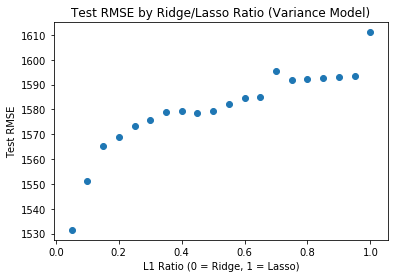

In [254]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Variance Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Variance Model Predicted vs. True Values (EN) [Combined Data]')

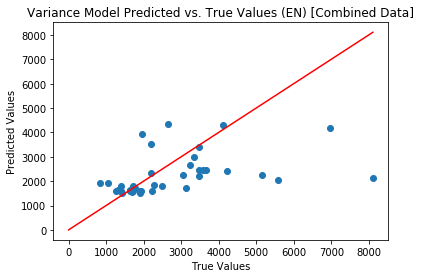

In [255]:
#Elastic Net
max_var = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_var)
plt.plot([0, max_var], [0, max_var], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Variance Model Predicted vs. True Values (EN) [Combined Data]")

In [256]:
model_name = "Variance"
source = "Old+New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_var, "EN_rmse":rmse_test_var_en, 
                                                      "L_mape": mape_test_var, "EN_mape":mape_test_var_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_var.coef_,
                                                      "test_set": test_set, "test_ind":test_ind, "train_ind":train_ind})),
                               ignore_index=True)

### Discharge Model [Combined Data]

In [257]:
variance_model_features = variance_model_features[:-4]
discharge_model_features = discharge_model_features[:-4]
full_model_features = full_model_features[:-4]

In [258]:
if scaled:
    
    all_model_features = discharge_model_features
    
    def scale(train, test=pd.DataFrame()):
        #print(type(test))
        scaler = RobustScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        if len(test) != 0:
            test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        else:
            test_data = 0
        return [train_data, test_data]
    
    if old_new_scaler:
        # old
        train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81, 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]
        X_train_all_old = old_ct.iloc[train_ind][all_model_features]

        X_train_all_old, X_test_all_old = scale(X_train_all_old)

        X_train_all_old[y] = old_ct.iloc[train_ind][y]

        X_all_old = X_train_all_old

        # new
        train_ind = [i for i in range(0, len(new_ct_full), 2)]
        test_ind = [i for i in range(1, len(new_ct_full), 2)]

        new_test_ind = test_ind

        if new_chemistries & chem_sources:
            all_model_features = all_model_features + chemistries
        X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_train_all_new.dropna(axis=0, inplace=True)
        X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_test_all_new.dropna(axis=0, inplace=True)

        X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

        X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
        X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
        X_all_new = X_train_all_new.append(X_test_all_new)  

In [259]:
if sources:
    old_ct["Source"] = -1
    new_ct_full["Source"] = 1
    variance_model_features.append("Source")
    discharge_model_features.append("Source")
    full_model_features.append("Source")

if new_chemistries & chem_sources:
    old_ct["X.LFP"] = new_ct_full.iloc[0]["X.LFP"]
    old_ct["X.NCA"] = new_ct_full.iloc[0]["X.NCA"]
    old_ct["X.NMC"] = new_ct_full.iloc[0]["X.NMC"]
    variance_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    discharge_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    full_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))

In [260]:
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

In [261]:
if scaled:
    if old_new_scaler:
        if sources:
            X_all_old["Source"] = -1
            X_all_new["Source"] = 1
            all_model_features.append("Source")
            
        if new_chemistries & chem_sources:
            X_all_old["X.LFP"] = 1
            X_all_old["X.NCA"] = -1
            X_all_old["X.NMC"] = -1

            for chem in chemistries:
                X_all_new[chem].replace(0, -1, inplace=True)
            
        full_data = X_all_old.append(X_all_new)
        full_data = full_data.reset_index()

In [262]:
if new_chemistries:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)
            
    elif test_set == "NCA":
        test_ind = list(full_data[full_data["X.NCA"] > 0].index)
        
    elif test_set == "NMC":
        test_ind = list(full_data[full_data["X.NMC"] > 0].index)
        
    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
    
else:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)

    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
        
train_ind = list(set(full_data.index) - set(test_ind))
#train_ind = list(full_data.iloc[:84].index) + [j for j in range(139, len(full_data),2)]

c:\users\mattm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


#### Linear Regression

In [263]:
# if environ:
#     discharge_model_features.remove("Temperature")
#     discharge_model_features.remove("DOD")
#     discharge_model_features.remove("Discharge_rate")
#     discharge_model_features.remove("Charge_rate")
X_train_dis = full_data.iloc[train_ind][discharge_model_features]
X_test_dis = full_data.iloc[test_ind][discharge_model_features]

# if environ:
#     discharge_model_features.extend(("Temperature", "DOD", "Discharge_rate", "Charge_rate"))
#     X_train_dis = full_data.iloc[X_train_dis.index][discharge_model_features]
#     X_test_dis = full_data.iloc[X_test_dis.index][discharge_model_features]
    
X_train_dis.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_dis.index][[y]]

X_test_dis.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_dis.index][[y]]

# if scaled:
#     if not old_new_scaler:
#         X_train_dis, X_test_dis = scale(X_train_dis, X_test_dis)
    
if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [264]:
reg_dis = LinearRegression().fit(X_train_dis,y_train)
y_pred_train_dis = reg_dis.predict(X_train_dis)
y_pred_test_dis = reg_dis.predict(X_test_dis)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_dis = np.exp(y_pred_train_dis)
    y_pred_test_dis = np.exp(y_pred_test_dis)

In [265]:
rmse_train_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_dis))
rmse_test_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_dis))
mape_train_dis = mean_absolute_percentage_error(y_train, y_pred_train_dis)*100
mape_test_dis = mean_absolute_percentage_error(y_test, y_pred_test_dis)*100

print("Discharge Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_dis)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_dis)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_dis))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_dis))

Discharge Basic Linear Regression Model
Test RMSE:  1788.290886937357
Mean % Test Error:  0.3671317170821506


Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (LR) [Combined Data]')

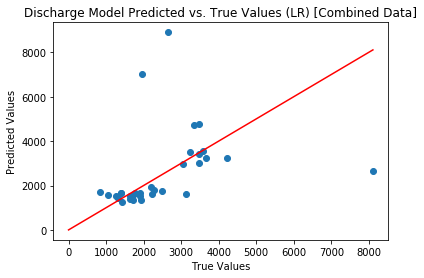

In [266]:
# Discharge model
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (LR) [Combined Data]")

#### Elastic Net

In [267]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    if log_transformation:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
    
    elasticnetcv.fit(X_train_dis, y_train.values.ravel())

    elasticnet_dis = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_dis.fit(X_train_dis, y_train.values.ravel())
    y_pred_train_en_dis = elasticnet_dis.predict(X_train_dis)
    y_pred_test_en_dis = elasticnet_dis.predict(X_test_dis)

    if log_transformation:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train_en_dis = np.exp(y_pred_train_en_dis)
        y_pred_test_en_dis = np.exp(y_pred_test_en_dis)

    
    rmse_train_en_dis = np.sqrt(mean_squared_error(y_train, y_pred_train_en_dis))
    rmse_test_en_dis = np.sqrt(mean_squared_error(y_test, y_pred_test_en_dis))
    mape_train_en_dis = mean_absolute_percentage_error(y_train, y_pred_train_en_dis)*100
    mape_test_en_dis = mean_absolute_percentage_error(y_test, y_pred_test_en_dis)*100

    models.append(elasticnet_dis)
    y_pred_trains.append(y_pred_train_en_dis)
    y_pred_tests.append(y_pred_test_en_dis)
    train_rmses.append(rmse_train_en_dis)
    test_rmses.append(rmse_test_en_dis)
    train_mapes.append(mape_train_en_dis)
    test_mapes.append(mape_test_en_dis)

best_model_index = test_rmses.index(min(test_rmses))

In [268]:
elasticnet_dis = models[best_model_index]
y_pred_train_en_dis = y_pred_trains[best_model_index]
y_pred_test_en_dis = y_pred_tests[best_model_index]
rmse_train_dis_en = train_rmses[best_model_index]
rmse_test_dis_en = test_rmses[best_model_index]
l1_ratio_dis = l1_ratios[best_model_index]
mape_train_dis_en = train_mapes[best_model_index]
mape_test_dis_en = test_mapes[best_model_index]

print("Discharge Elastic Net Model")
print("l1_ratio =", l1_ratio_dis)
print("Test RMSE: ", rmse_test_dis_en)
print("Test Mean Absolute % Error: ", mape_test_dis_en)

Discharge Elastic Net Model
l1_ratio = 0.9
Test RMSE:  1463.294310344929
Test Mean Absolute % Error:  32.85798118160784


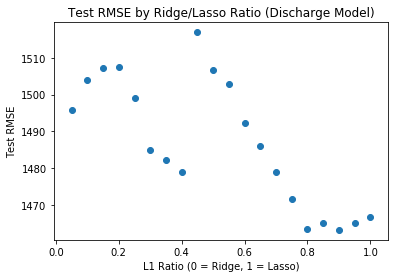

In [269]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Discharge Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Discharge Model Predicted vs. True Values (EN) [Combined Data]')

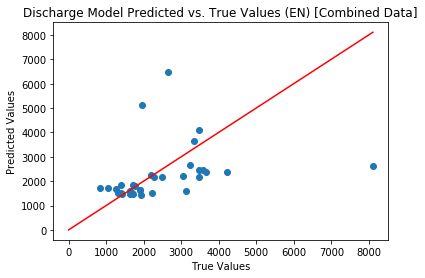

In [270]:
#Elastic Net
max_dis = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_dis)
plt.plot([0, max_dis], [0, max_dis], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Discharge Model Predicted vs. True Values (EN) [Combined Data]")

In [271]:
model_name = "Discharge"
source = "Old+New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_dis, "EN_rmse":rmse_test_dis_en, 
                                                      "L_mape": mape_test_dis, "EN_mape":mape_test_dis_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_dis.coef_,
                                                      "test_set": test_set, "test_ind":test_ind, "train_ind":train_ind})),
                               ignore_index=True)

### Full Model [Combined Data]

In [272]:
variance_model_features = variance_model_features[:-4]
discharge_model_features = discharge_model_features[:-4]
full_model_features = full_model_features[:-4]

In [273]:
if scaled:
    
    all_model_features = full_model_features
    
    def scale(train, test=pd.DataFrame()):
        #print(type(test))
        scaler = RobustScaler()
        scaler.fit(train)
        train_data = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
        if len(test) != 0:
            test_data = pd.DataFrame(scaler.transform(test), index=test.index, columns = test.columns)
        else:
            test_data = 0
        return [train_data, test_data]
    
    if old_new_scaler:
        # old
        train_ind = [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
        35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
        69, 71, 73, 75, 77, 79, 81, 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 83]
        X_train_all_old = old_ct.iloc[train_ind][all_model_features]

        X_train_all_old, X_test_all_old = scale(X_train_all_old)

        X_train_all_old[y] = old_ct.iloc[train_ind][y]

        X_all_old = X_train_all_old

        # new
        train_ind = [i for i in range(0, len(new_ct_full), 2)]
        test_ind = [i for i in range(1, len(new_ct_full), 2)]

        new_test_ind = test_ind

        if new_chemistries & chem_sources:
            all_model_features = all_model_features + chemistries
        X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_train_all_new.dropna(axis=0, inplace=True)
        X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
        X_test_all_new.dropna(axis=0, inplace=True)

        X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

        X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
        X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
        X_all_new = X_train_all_new.append(X_test_all_new)  

In [274]:
if sources:
    old_ct["Source"] = -1
    new_ct_full["Source"] = 1
    variance_model_features.append("Source")
    discharge_model_features.append("Source")
    full_model_features.append("Source")

if new_chemistries & chem_sources:
    old_ct["X.LFP"] = new_ct_full.iloc[0]["X.LFP"]
    old_ct["X.NCA"] = new_ct_full.iloc[0]["X.NCA"]
    old_ct["X.NMC"] = new_ct_full.iloc[0]["X.NMC"]
    variance_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    discharge_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))
    full_model_features.extend(("X.LFP", "X.NCA", "X.NMC"))

In [275]:
full_data = old_ct.append(new_ct_full)
full_data = full_data.reset_index()

In [276]:
if scaled:
    if old_new_scaler:
        if sources:
            X_all_old["Source"] = -1
            X_all_new["Source"] = 1
            all_model_features.append("Source")
            
        if new_chemistries & chem_sources:
            X_all_old["X.LFP"] = 1
            X_all_old["X.NCA"] = -1
            X_all_old["X.NMC"] = -1

            for chem in chemistries:
                X_all_new[chem].replace(0, -1, inplace=True)
            
        full_data = X_all_old.append(X_all_new)
        full_data = full_data.reset_index()

In [277]:
if new_chemistries:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)
            
    elif test_set == "NCA":
        test_ind = list(full_data[full_data["X.NCA"] > 0].index)
        
    elif test_set == "NMC":
        test_ind = list(full_data[full_data["X.NMC"] > 0].index)
        
    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
    
else:
    if test_set == "combination":
        test_ind = [i for i in range(0, len(full_data), 2)]
            
    elif test_set == "new":
        test_ind = [j for j in range(len(old_ct),len(full_data))]
        
    elif test_set == "half new":
        test_ind = [j for j in range(len(old_ct)+1,len(full_data),2)]

    elif test_set == "new unchanged":
        test_ind = list(full_data.iloc[84:][full_data["index"].isin(new_test_ind)].index)
        
    elif test_set == "LFP":
        test_ind = list(full_data.iloc[len(old_ct):][(full_data["X.LFP"] > 0)].index)

    elif test_set == "old":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        
    elif test_set == "half":
        test_ind = list(full_data.iloc[84:len(old_ct)].index)
        test_ind = test_ind + [j for j in range(len(old_ct)+1,len(full_data),2)]
        
train_ind = list(set(full_data.index) - set(test_ind))
#train_ind = list(full_data.iloc[:84].index) + [j for j in range(139, len(full_data),2)]

c:\users\mattm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


#### Linear Regression

In [278]:
# if scaled:
#     if old_new_scaler:
#         if new_chemistries & chem_sources:
#             all_model_features = all_model_features + chemistries
#         X_train_all_new = new_ct_full.iloc[train_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
#         X_train_all_new.dropna(axis=0, inplace=True)
#         X_test_all_new = new_ct_full.iloc[test_ind][all_model_features].replace([np.inf, -np.inf, 0], np.nan)
#         X_test_all_new.dropna(axis=0, inplace=True)

#         X_train_all_new, X_test_all_new = scale(X_train_all_new, X_test_all_new)

#         X_train_all_new[y] = new_ct_full.iloc[train_ind][y]
#         X_test_all_new[y] = new_ct_full.iloc[test_ind][y]
        
#         X_all_new = X_train_all_new.append(X_test_all_new)

In [279]:
X_train_full = full_data.iloc[train_ind][full_model_features]
X_test_full = full_data.iloc[test_ind][full_model_features]
    
X_train_full.dropna(axis=0, inplace=True)
y_train = full_data.iloc[X_train_full.index][[y]]

X_test_full.dropna(axis=0, inplace=True)
y_test = full_data.iloc[X_test_full.index][[y]]

if log_transformation:
    y_train = np.log(y_train)
    y_test = np.log(y_test)

In [280]:
reg_full = LinearRegression().fit(X_train_full,y_train)
y_pred_train_full = reg_full.predict(X_train_full)
y_pred_test_full = reg_full.predict(X_test_full)

if log_transformation:
    y_train = np.exp(y_train)
    y_test = np.exp(y_test)
    y_pred_train_full = np.exp(y_pred_train_full)
    y_pred_test_full = np.exp(y_pred_test_full)

In [281]:
rmse_train_full = np.sqrt(mean_squared_error(y_train, y_pred_train_full))
rmse_test_full = np.sqrt(mean_squared_error(y_test, y_pred_test_full))
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full)*100
mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full)*100

print("Full Basic Linear Regression Model")
# print("Training RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train_full)))
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_test_full)))
# print("Mean % Train Error: ", mean_absolute_percentage_error(y_train, y_pred_train_full))
print("Mean % Test Error: ", mean_absolute_percentage_error(y_test, y_pred_test_full))

Full Basic Linear Regression Model
Test RMSE:  1680.2795405423155
Mean % Test Error:  0.33777969800678925


Text(0.5, 1.0, 'Full Model Predicted vs. True Values (LR) [Combined Data]')

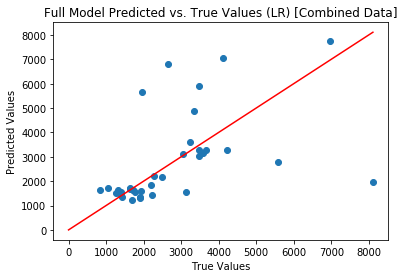

In [282]:
# Linear Regression
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (LR) [Combined Data]")

#### Elastic Net

In [283]:
k_fold = 5
l1_ratios = [i/20 for i in range(1, 21)]
max_iter = 1000000
random_state = 1
test_size = 2
tol = 0.0001

models = []
y_pred_trains = []
y_pred_tests = []
train_rmses = []
test_rmses = []
train_mapes = []
test_mapes = []

for l1_ratio in l1_ratios:
    elasticnetcv = ElasticNetCV(
        fit_intercept=True,
        normalize=False,
        alphas=None,
        cv=k_fold,
        l1_ratio=l1_ratio,
        max_iter=max_iter,
    )
    
    if log_transformation:
        y_train = np.log(y_train)
        y_test = np.log(y_test)
        
    elasticnetcv.fit(X_train_full, y_train.values.ravel())

    elasticnet_full = ElasticNet(
        fit_intercept=True,
        normalize=False,
        l1_ratio=elasticnetcv.l1_ratio_,
        alpha=elasticnetcv.alpha_,
        max_iter=max_iter,
    )

    elasticnet_full.fit(X_train_full, y_train.values.ravel())
    y_pred_train_en_full = elasticnet_full.predict(X_train_full)
    y_pred_test_en_full = elasticnet_full.predict(X_test_full)

    if log_transformation:
        y_train = np.exp(y_train)
        y_test = np.exp(y_test)
        y_pred_train_en_full = np.exp(y_pred_train_en_full)
        y_pred_test_en_full = np.exp(y_pred_test_en_full)
        
    rmse_train_en_full = np.sqrt(mean_squared_error(y_train, y_pred_train_en_full))
    rmse_test_en_full = np.sqrt(mean_squared_error(y_test, y_pred_test_en_full))
    mape_train_en_full = mean_absolute_percentage_error(y_train, y_pred_train_en_full)*100
    mape_test_en_full = mean_absolute_percentage_error(y_test, y_pred_test_en_full)*100

    models.append(elasticnet_full)
    y_pred_trains.append(y_pred_train_en_full)
    y_pred_tests.append(y_pred_test_en_full)
    train_rmses.append(rmse_train_en_full)
    test_rmses.append(rmse_test_en_full)
    train_mapes.append(mape_train_en_full)
    test_mapes.append(mape_test_en_full)

best_model_index = test_rmses.index(min(test_rmses))

In [284]:
elasticnet_full = models[best_model_index]
y_pred_train_en_full = y_pred_trains[best_model_index]
y_pred_test_en_full = y_pred_tests[best_model_index]
rmse_train_full_en = train_rmses[best_model_index]
rmse_test_full_en = test_rmses[best_model_index]
l1_ratio_full = l1_ratios[best_model_index]
mape_train_full_en = train_mapes[best_model_index]
mape_test_full_en = test_mapes[best_model_index]

print("Full Elastic Net Model")
print("l1_ratio =", l1_ratio_full)
print("Test RMSE: ", rmse_test_full_en)
print("Test Mean Absolute % Error: ", mape_test_full_en)

Full Elastic Net Model
l1_ratio = 0.05
Test RMSE:  1521.5458577010872
Test Mean Absolute % Error:  33.176548975505085


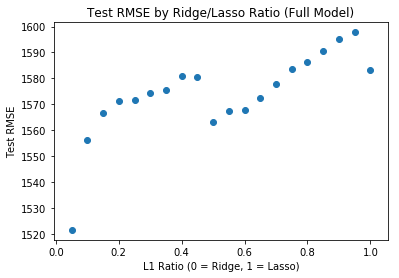

In [285]:
plt.scatter(l1_ratios, test_rmses)
plt.title("Test RMSE by Ridge/Lasso Ratio (Full Model)")
plt.xlabel("L1 Ratio (0 = Ridge, 1 = Lasso)")
plt.ylabel("Test RMSE");

Text(0.5, 1.0, 'Full Model Predicted vs. True Values (EN) [Combined Data]')

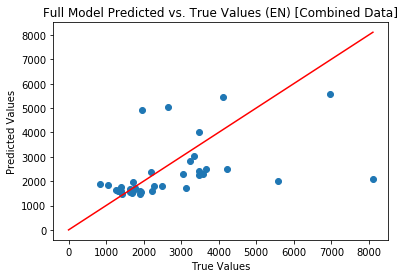

In [286]:
#Elastic Net
max_full = y_test.max()[0]

plt.scatter(y_test, y_pred_test_en_full)
plt.plot([0, max_full], [0, max_full], color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Full Model Predicted vs. True Values (EN) [Combined Data]")

In [287]:
model_name = "Full"
source = "Old+New"

results_df = results_df.append(cond.append(pd.Series({"L_rmse": rmse_test_full, "EN_rmse":rmse_test_full_en, 
                                                      "L_mape": mape_test_full, "EN_mape":mape_test_full_en, 
                                                      "model":model_name, "data":source, "coef":elasticnet_full.coef_,
                                                      "test_set": test_set, "test_ind":test_ind, "train_ind":train_ind})),
                               ignore_index=True)

In [288]:
results_df

,EN_mape,EN_rmse,L_mape,L_rmse,coef,ct,data,environ,ir,log_y,model,other_chem,separate_scaler,sources_ind,standardized,time_temp_cycle,test_ind,test_set,train_ind
0,14.846083,214.314909,14.850106,214.300599,[-470.4674340138828],1.0,Old,0.0,0.0,1.0,Variance,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN
1,17.042336,320.487572,19.830829,335.350991,"[-98.68914706029473, -125.29539557843025, 30.2...",1.0,Old,0.0,0.0,1.0,Discharge,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN
2,14.131775,202.130177,16.906216,216.141783,"[-268.91167504993365, -190.43748661936687, -22...",1.0,Old,0.0,0.0,1.0,Full,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN
3,47.882224,1499.261368,38.116339,1433.868948,"[-98.39616783301058, 68.17179879945441, -66.83...",1.0,New,0.0,0.0,1.0,Variance,1.0,1.0,1.0,1.0,0.0,"[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25...",NaN,NaN
4,30.022132,1243.601581,28.594938,1239.570689,"[-0.0, -80.99040460697205, 0.0, 2.846586508262...",1.0,New,0.0,0.0,1.0,Discharge,1.0,1.0,1.0,1.0,0.0,"[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25...",NaN,NaN
5,32.769226,1386.746951,27.912812,1218.329310,"[-0.0, -0.0, 0.0, -1324.194815217725, -0.0, 0....",1.0,New,0.0,0.0,1.0,Full,1.0,1.0,1.0,1.0,0.0,"[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25...",NaN,NaN
6,33.602534,1591.111650,35.289598,1669.177613,"[-0.40529453864425796, 0.42175628367523676, 0....",1.0,Old+New,0.0,0.0,1.0,Variance,1.0,1.0,1.0,1.0,0.0,"[123, 124, 125, 126, 127, 128, 129, 130, 131, ...",new unchanged,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
7,31.288182,1444.697143,33.032558,1604.886094,"[-0.16451922465527302, -0.13238455086014314, 0...",1.0,Old+New,0.0,0.0,1.0,Discharge,1.0,1.0,1.0,1.0,0.0,"[117, 118, 119, 120, 121, 122, 123, 124, 125, ...",new unchanged,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
8,33.141449,1667.263300,32.528785,1652.426611,"[-0.15785695622969897, -0.07239337317810342, 0...",1.0,Old+New,0.0,0.0,1.0,Full,1.0,1.0,1.0,1.0,0.0,"[122, 123, 124, 125, 126, 127, 128, 129, 130, ...",new unchanged,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
9,14.846083,214.314909,14.850106,214.300599,"[-470.4674340138828, 0.0, 0.0, 0.0, 0.0]",1.0,Old,1.0,0.0,1.0,Variance,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN


In [289]:
results_df.groupby(["data", "model", "environ"]).describe()

EN_mape                                       \
                            count       mean std        min        25%   
data    model     environ                                                
New     Discharge 0.0         1.0  30.022132 NaN  30.022132  30.022132   
                  1.0         1.0  40.560623 NaN  40.560623  40.560623   
        Full      0.0         1.0  32.769226 NaN  32.769226  32.769226   
                  1.0         1.0  36.528570 NaN  36.528570  36.528570   
        Variance  0.0         1.0  47.882224 NaN  47.882224  47.882224   
                  1.0         1.0  48.602164 NaN  48.602164  48.602164   
Old     Discharge 0.0         1.0  17.042336 NaN  17.042336  17.042336   
                  1.0         1.0  17.042336 NaN  17.042336  17.042336   
        Full      0.0         1.0  14.131775 NaN  14.131775  14.131775   
                  1.0         1.0  14.131775 NaN  14.131775  14.131775   
        Variance  0.0         1.0  14.846083 NaN  14.846083  14.846083   
                  1.0         1.0  14.846083 NaN  14.846083  14.846083   
Old+New Discharge 0.0         1.0  31.288182 NaN  31.288182  31.288182   
                  1.0         1.0  32.857981 NaN  32.857981  32.857981   
        Full      0.0         1.0  33.141449 NaN  33.141449  33.141449   
                  1.0         1.0  33.176549 NaN  33.176549  33.176549   
        Variance  0.0         1.0  33.602534 NaN  33.602534  33.602534   
                  1.0         1.0  31.893188 NaN  31.893188  31.893188   

                                                           EN_rmse  \
                                 50%        75%        max   count   
data    model     environ                                            
New     Discharge 0.0      30.022132  30.022132  30.022132     1.0   
                  1.0      40.560623  40.560623  40.560623     1.0   
        Full      0.0      32.769226  32.769226  32.769226     1.0   
                  1.0      36.528570  36.528570  36.528570     1.0   
        Variance  0.0      47.882224  47.882224  47.882224     1.0   
                  1.0      48.602164  48.602164  48.602164     1.0   
Old     Discharge 0.0      17.042336  17.042336  17.042336     1.0   
                  1.0      17.042336  17.042336  17.042336     1.0   
        Full      0.0      14.131775  14.131775  14.131775     1.0   
                  1.0      14.131775  14.131775  14.131775     1.0   
        Variance  0.0      14.846083  14.846083  14.846083     1.0   
                  1.0      14.846083  14.846083  14.846083     1.0   
Old+New Discharge 0.0      31.288182  31.288182  31.288182     1.0   
                  1.0      32.857981  32.857981  32.857981     1.0   
        Full      0.0      33.141449  33.141449  33.141449     1.0   
                  1.0      33.176549  33.176549  33.176549     1.0   
        Variance  0.0      33.602534  33.602534  33.602534     1.0   
                  1.0      31.893188  31.893188  31.893188     1.0   

                                        ... standardized      time_temp_cycle  \
                                  mean  ...          75%  max           count   
data    model     environ               ...                                     
New     Discharge 0.0      1243.601581  ...          1.0  1.0             1.0   
                  1.0      1137.446651  ...          1.0  1.0             1.0   
        Full      0.0      1386.746951  ...          1.0  1.0             1.0   
                  1.0      1302.662862  ...          1.0  1.0             1.0   
        Variance  0.0      1499.261368  ...          1.0  1.0             1.0   
                  1.0      1430.500940  ...          1.0  1.0             1.0   
Old     Discharge 0.0       320.487572  ...          1.0  1.0             1.0   
                  1.0       320.487572  ...          1.0  1.0             1.0   
        Full      0.0       202.130177  ...          1.0  1.0             1.0   
                  1.0       

In [290]:
import math
def checker(l1, l2):
    #print(l1, "\n", l2)
    if type(l1) != list or type(l2) != list:
        return None
    for i in range(len(l1)):
        if l1[i] in l2:
            return False
    return True

In [291]:
for i in range(len(results_df)):
    print("Index:", i, "Good:?", checker(results_df.loc[i, "test_ind"], results_df.loc[i, "train_ind"]))

Index: 0 Good:? None
Index: 1 Good:? None
Index: 2 Good:? None
Index: 3 Good:? None
Index: 4 Good:? None
Index: 5 Good:? None
Index: 6 Good:? True
Index: 7 Good:? True
Index: 8 Good:? True
Index: 9 Good:? None
Index: 10 Good:? None
Index: 11 Good:? None
Index: 12 Good:? None
Index: 13 Good:? None
Index: 14 Good:? None
Index: 15 Good:? True
Index: 16 Good:? True
Index: 17 Good:? True


In [292]:
stop

NameError: name 'stop' is not defined

Environment Variables + Only LFP

In [ ]:
plot_df = results_df[((results_df.test_set == "old") | (results_df.test_set == "half new") | (results_df.test_set == "half")) 
                     & (results_df.environ == 1.0) & (results_df.other_chem == 0.0)].set_index("test_set")

In [ ]:
custom_dict = {'old': 0, 'half new': 1, 'half': 2} 
plot_df#.sort_values("t", key=lambda x: x.map(custom_dict))

In [ ]:
plot_df.sort_values("model", key=lambda x: x.map(custom_dict)).loc["old", "EN_mape"].values

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["Old", "Half New", "Old+New"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Variance", "EN_mape"].values), width, label=kind[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Discharge", "EN_mape"].values), width, label=kind[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Full", "EN_mape"].values), width, label=kind[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAPE')
ax.set_title('MAPE by Model and Test Set (EN)')
ax.set_xticks(x)
ax.set_xticklabels(data)
ax.set_ylim([0,100])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

No Environment Variables + Only LFP

In [ ]:
plot_df = results_df[((results_df.test_set == "old") | (results_df.test_set == "half new") | (results_df.test_set == "half")) 
                     & (results_df.environ == 0.0) & (results_df.other_chem == 0.0)].set_index("test_set")

In [ ]:
custom_dict = {'old': 0, 'half new': 1, 'half': 2} 
plot_df#.sort_values("t", key=lambda x: x.map(custom_dict))

In [ ]:
plot_df.sort_values("model", key=lambda x: x.map(custom_dict)).loc["old", "EN_mape"].values

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["Old", "Half New", "Old+New"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Variance", "EN_mape"].values), width, label=kind[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Discharge", "EN_mape"].values), width, label=kind[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Full", "EN_mape"].values), width, label=kind[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAPE')
ax.set_title('MAPE by Model and Test Set (EN)')
ax.set_xticks(x)
ax.set_xticklabels(data)
ax.set_ylim([0,100])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

Environment Variables + All Chem

In [ ]:
plot_df = results_df[((results_df.test_set == "old") | (results_df.test_set == "half new") | (results_df.test_set == "half")) 
                     & (results_df.environ == 1.0) & (results_df.other_chem == 1.0)].set_index("test_set")

In [ ]:
custom_dict = {'old': 0, 'half new': 1, 'half': 2} 
plot_df#.sort_values("t", key=lambda x: x.map(custom_dict))

In [ ]:
plot_df.sort_values("model", key=lambda x: x.map(custom_dict)).loc["old", "EN_mape"].values

In [ ]:
kind = ["Variance", "Discharge", "Full"]
data = ["Old", "Half New", "Old+New"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Variance", "EN_mape"].values), width, label=kind[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Discharge", "EN_mape"].values), width, label=kind[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Full", "EN_mape"].values), width, label=kind[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAPE')
ax.set_title('MAPE by Model and Test Set (EN)')
ax.set_xticks(x)
ax.set_xticklabels(data)
ax.set_ylim([0,100])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

No Environment Variables + All Chems

In [ ]:
plot_df = results_df[((results_df.test_set == "old") | (results_df.test_set == "half new") | (results_df.test_set == "half")) 
                     & (results_df.environ == 0.0) & (results_df.other_chem == 1.0)].set_index("test_set")

custom_dict = {'old': 0, 'half new': 1, 'half': 2} 
plot_df#.sort_values("t", key=lambda x: x.map(custom_dict))

#plot_df.sort_values("model", key=lambda x: x.map(custom_dict)).loc["old", "EN_mape"].values

kind = ["Variance", "Discharge", "Full"]
data = ["Old", "Half New", "Old+New"]#, "Old+New"]
x = np.arange(len(kind))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Variance", "EN_mape"].values), width, label=kind[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Discharge", "EN_mape"].values), width, label=kind[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("model").sort_values("test_set", key=lambda x: x.map(custom_dict)).
                              loc["Full", "EN_mape"].values), width, label=kind[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAPE')
ax.set_title('MAPE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(data)
ax.set_ylim([0,35])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

In [ ]:
for x in results_df[(results_df.test_set == "half new")
            & (results_df.environ == 0.0) & (results_df.other_chem == 1.0)].set_index("test_set").coef:
    print(x)

In [ ]:
stop

In [ ]:
results_df.drop([63, 64, 65], axis=0, inplace=True)

In [ ]:
plot_df.reset_index().set_index("model").sort_values("data", key=lambda x: x.map(custom_dict)).loc["Variance", "EN_mape"].values

In [ ]:
plot_df.iloc[[0, 1, 2]].index

In [ ]:
results_df.columns

In [ ]:
plot_df = results_df[((results_df.test_set == "new unchanged") | (results_df.data == "New")) 
           & (results_df.other_chem == 1.0) & (results_df.environ == 0.0) & (results_df.time_temp_cycle == 0.0)].set_index("data")

custom_dict = {'New': 0, 'Old+New': 1} 
plot_df#.sort_values("t", key=lambda x: x.map(custom_dict))

#plot_df.sort_values("model", key=lambda x: x.map(custom_dict)).loc["old", "EN_mape"].values

kind = ["Variance", "Discharge", "Full"]
data = ["New", "Combined"]#, "Old+New"]
x = np.arange(len(data))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("model").sort_values("data", key=lambda x: x.map(custom_dict)).
                              loc["Variance", "EN_mape"].values), width, label=kind[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("model").sort_values("data", key=lambda x: x.map(custom_dict)).
                              loc["Discharge", "EN_mape"].values), width, label=kind[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("model").sort_values("data", key=lambda x: x.map(custom_dict)).
                              loc["Full", "EN_mape"].values), width, label=kind[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAPE')
ax.set_title('MAPE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(data)
ax.set_ylim([0,50])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

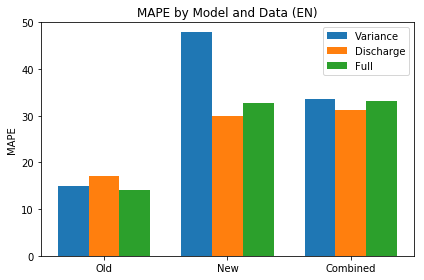

In [293]:
plot_df = results_df[((results_df.test_set == "new unchanged") | (results_df.data == "New") | (results_df.data == "Old")) 
           & (results_df.other_chem == 1.0) & (results_df.environ == 0.0) & (results_df.time_temp_cycle == 0.0)].set_index("data")

custom_dict = {'Old': 0, 'New': 1, 'Old+New': 2} 
plot_df#.sort_values("t", key=lambda x: x.map(custom_dict))

#plot_df.sort_values("model", key=lambda x: x.map(custom_dict)).loc["old", "EN_mape"].values

kind = ["Variance", "Discharge", "Full"]
data = ["Old", "New", "Combined"]#, "Old+New"]
x = np.arange(len(data))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, (plot_df.reset_index().set_index("model").sort_values("data", key=lambda x: x.map(custom_dict)).
                              loc["Variance", "EN_mape"].values), width, label=kind[0])
rects2 = ax.bar(x, (plot_df.reset_index().set_index("model").sort_values("data", key=lambda x: x.map(custom_dict)).
                              loc["Discharge", "EN_mape"].values), width, label=kind[1])
rects3 = ax.bar(x + width, (plot_df.reset_index().set_index("model").sort_values("data", key=lambda x: x.map(custom_dict)).
                              loc["Full", "EN_mape"].values), width, label=kind[2])
# rects2 = ax.bar(x, plot_df.reset_index().set_index("model").loc["Discharge", "EN_rmse"].values,
#                 width, label=data[1])
# rects3 = ax.bar(x + width, plot_df.reset_index().set_index("model").loc["Full", "EN_rmse"].values,
#                 width, label=data[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAPE')
ax.set_title('MAPE by Model and Data (EN)')
ax.set_xticks(x)
ax.set_xticklabels(data)
ax.set_ylim([0,50])
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()
#L + no time_integrated

In [ ]:
plot_df

In [ ]:
results_df[((results_df.test_set == "new unchanged") | (results_df.data == "New")) 
           & (results_df.other_chem == 1.0)].groupby(["data",  "model", "environ"]).describe()

In [ ]:
sns.distplot(old_ct[y], kde=False, color="yellow", label='Old Data', bins=5)
sns.distplot(new_ct_full[y], kde=False, color="red", label='New Data', bins=10)

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

In [ ]:
sns.histplot(new_ct_full[y], color="red", label='New Data')
sns.histplot(full_data[y], color = "yellow", label = 'Combined Data')
sns.histplot(old_ct[y], color="blue", label='Old Data')

# Plot formatting
plt.legend(prop={'size': 12})
if ct:
    plt.title('Average Charge Throughput of Data Sources')
    plt.xlabel('Charge Throughput')
else:
    plt.title('Average Cycle Life of Data Sources')
    plt.xlabel('Cycle Life')
plt.ylabel('Frequency');

In [ ]:
all_data_metrics = pd.DataFrame(data = {
    
                               "Model & Source": ["Var (Linear)", "Var (E.N.)", 
                                                  "Disc (Linear)", "Disc (E.N.)",
                                                  "Full (Linear)", "Full (E.N.)"],
                               
                               "Model": ["Variance", "Variance",
                                         "Discharge", "Discharge",
                                         "Full", "Full"],
                                        
                               "Source": ["Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net",
                                          "Basic Linear Regression", "Elastic Net"],
                                        
                               "Train RMSE": [rmse_train_var, rmse_train_var_en,
                                              rmse_train_dis, rmse_train_dis_en,
                                              rmse_train_full, rmse_train_full_en],
                               
                               "Test RMSE": [rmse_test_var, rmse_test_var_en,
                                             rmse_test_dis, rmse_test_dis_en,
                                             rmse_test_full, rmse_test_full_en],
                               
                               "Train MAPE": [mape_train_var, mape_train_var_en,
                                              mape_train_dis, mape_train_dis_en,
                                              mape_train_full, mape_train_full_en],
                               
                               "Test MAPE": [mape_test_var, mape_test_var_en,
                                             mape_test_dis, mape_test_dis_en,
                                             mape_test_full, mape_test_full_en]
})

In [ ]:
for column in all_data_metrics.columns[3:]:
    sns.catplot(data = all_data_metrics, kind="bar",
               x = "Model", y = column, hue = "Source")
    plt.title(column + " Comparison [Combined Data]")

In [ ]:
enet_mapes = []
enet_rmses = []
lr_mapes = []
lr_rmses = []

for data in [old_data_metrics, new_data_metrics, all_data_metrics]:
    for i in range(1, 6, 2):
        enet_mapes.append(data.iloc[i]["Test MAPE"])
        enet_rmses.append(data.iloc[i]["Test RMSE"])

    for i in range(0, 6, 2):
        lr_mapes.append(data.iloc[i]["Test MAPE"])
        lr_rmses.append(data.iloc[i]["Test RMSE"])

all_metrics = pd.DataFrame(data = {
    
    "Model": ["Basic Linear Regression"]*9 + ["Elastic Net"]*9,
    
    "Data Source": ["Old"]*3 + ["New"]*3 + ["Combined"]*3 + ["Old"]*3 + ["New"]*3 + ["Combined"]*3,
    
    "Model Features": ["Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full",
                       "Variance", "Discharge", "Full"],
    
    "Mean Absolute Percent Error": lr_mapes + enet_mapes,
    
    "RSME": lr_rmses + enet_rmses
})

In [ ]:
sns.catplot(data = all_metrics, kind="bar",
            x = "Data Source", y = "Mean Absolute Percent Error", hue = "Model Features")
plt.title("Test MAPE Comparison");

In [ ]:
sns.catplot(data = all_metrics, kind="bar",
            x = "Model", y = "Mean Absolute Percent Error", hue = "Model Features", col="Data Source")
plt.title("Elastic Net MAPE Comparison");